# Numerik III, Notebook 5: Adaptive Schrittweitensteuerung

Dieses Notebook behandelt 
+ das Konzept einer adaptiven Schrittweitensteuerung 
+ Eingebettete Runge-Kutta-Verfahren 
+ Eine Projektaufgabe zur Implementierung und zum Test eines eingebetteten Runte-Kutta-Verfahrens mit adaptiver Schrittweitensteuerung.


**Ziel:** Mit möglichst wenig Zeitschritten soll eine vorgegebene Genauigkeit der numerischen Lösung erreicht werden. 

**Idee:** Wähle unterschiedliche problemangepasste Zeitschritten $h_k$ während der Berechnung. Da die Lösung $y(t)$ nicht vorher bekannt ist, müssen geeignete Schrittweiten während der Berechnung gewählt werden.


(Effizienz-Bewertung eines Diskretisierungsverfahrens eines numerischen Lösers für AWPe: Wieviele Funktionsauswertungen der rechten Seite sind für eine vorgebene Fehlertoleranz notwendig. Dies kann an AWPen evaluiert werden, deren Lösung analytisch berechenbar ist. Im Allgemeinen ist dieses Maß für die Effizienz nur empirisch durch numerische Experimente bestimmbar. Allerdings führt die mathematische Analyse möglicher Diskretisierungsverfahren zur Konstruktion geeigneter Verfahren.) 

## Populäre Strategie (für ESV)

1. In jedem Schritt $y^{j} \longrightarrow y^{j+1}$ wird *adaptiv* eine geeignete Schrittweite $h_j = t_{j+1} - t_j$ gewählt.

2. Wir versuchen, den lokalen Fehler $\delta_j:= \delta(t_j, h_j)$ zu kontrollieren

3. These: *Ein gleichverteilter Fehler ergibt ein optimales Gitter* (das ist nicht beweisbar, und stimmt auch nicht immer). D.h. wir geben eine Toleranz $tol$ vor, und fordern, dass in jedem Zeitschritt der lokale Fehler kleiner als diese Toleranz ist (bei Systemen ist der Fehler vektorwertig, daher wird hier noch irgendeine Norm auf $\mathbb{R}^n$ genommen):

$$
  \| \delta(t_j, h_j \| \leq tol, \qquad \text{idealerweise }\, \| \delta(t_j, h_j \| \approx tol
$$

4. Leider ist $\delta_j := \delta(t_j, h_j)$ nicht bekannt, so dass wir nicht ohne weiteres aus der obigen Ungleichung ein geeignetes $h_j$ bestimmen können. Wir benötigen daher einen berechenbaren Fehlerschätzer $s_j \approx \delta_j$. Dieser kann im Allgemeinen erst nach der Bestimmung von $y^{j+1}$ berechnet werden. Um die Berechnung eines solchen Fehlerschätzers kümmern wir uns später. Falls also $s_j$ ein guter Fehlerschäzter ist, dann hätten wir gerne, dass

$$
  \| s_j \| \leq tol, \qquad \text{idealerweise }\, \| s_j \| \approx tol.
$$

5. Wir berechnen jetzt *im Nachhinein*, was die *optimale Schrittweite* gewesen wäre. Wir bestimmen also zunächst den Wert $\| s_j \|$. Wir dagehen von aus, dass unser Diskretisierungverfahren die Konsistenzordnung $p$ hat. Dann hat der lokale Fehler $\delta(t, h)$ die Fehlerordnung $p+1$ und damit gilt das auch für den Fehlerschätzer $s_j$:

$$
\| s_j \| \approx \| \delta(t_j, h_j) \| \leq c h_j ^{p+1}
$$

Die einzige Unbekannte ist hier die Konstante $c$. 
Wir setzen jetzt in der obigen Gleichung das $\leq$ durch ein $\approx$ (das ist eine Annahme an den Fehlerschätzer bzw. an das Diskretisierungsverfahren !) und berechnen eine Schrittweite $h_\mathrm{opt}$, so dass wir mit dieser Schrittweite genau die geforderte Toleranz $tol$ erreicht hätten. Zur Sicherheit fordern wir mit einen Faktor $0< \rho < 1$ (üblich ist z.B.  $\rho = 0.9$)

$$
\rho \, tol = c h_\mathrm{opt}^{p+1}, \qquad \text{mit} \quad c =  \frac{ \| s_j \|}{h_j ^{p+1}}.
$$

Auflösen nach $h_\mathrm{opt}$ ergibt dann schließlich die gesuchte Formel für einen (unter den zahlreichen getroffenen Annahmen) optimalen Schrittweitenvorschlag (nicht zu klein, nicht zu groß)
    
$$
  \boxed{  h_\mathrm{opt} = h_j \Big( \frac{\rho \, tol}{\| s_j \|} \Big)^{\frac{1}{p+1}} }
$$

6. Falls im Schritt $y^{j} \rightarrow y^{j+1}$ die geforderte Toleranz $tol$ nicht erreicht wurde, dann wird die Berechnung $y^{j+1}$ mit dem neuen Zeitschritt $h_j := h_\mathrm{opt}$ wiederholt. Falls die Toleranz erreicht wurde, dann wird der nächste Zeitschritt mit der SChrittweite $h_{j+1} := h_\mathrm{opt}$ ausgeführt

7. Es werden im Allgemeinen noch eine minimal erlaubte Schrittweite $h_\mathrm{min}$ und eine maximal erlaubte Schrittweite $h_\mathrm{max}$ festgelegt. Wird die minimale Schrittweite unterschritten, so soll das Verfahren abbrechen -- die Rechenzeit würde dann zu groß werden. Außerdem wird ein maximaler Hochschaltfaktor $q > 1$ festgelegt: Die Schrittweite darf sich in einem Schritt nur maximal um einen Faktor $q$ vergrößern. Dies ist zum Beispiel deswegen notwendig, weil in einem Schritt der Fehler (zufällig oder tatsächlich) fast Null sein kann. Dann darf das Verfahren aber nicht im nächsten Zeitschritt zu weit fortschreiten, z.B. über die nächste komplizierte Stelle.

Damit ergibt sich der folgende 
**Adaptiver Grundalgorithmus:**   

   
-------------------------------------------------------------------------------------------------
\begin{align}
& \text{Input: }  \text{AWP} (f, \, y^0, \, t_0, \, t_f); \\
& \qquad  \text{ Parameter } tol, \, \rho, \, q, \, h_\mathrm{max}, \, h_\mathrm{min}  \\
& \\
& j = 0 &\\
& h_0 = h_\mathrm{max} \\
& \textbf{while} \,\,  t_j < t_f \\
& \qquad    t = t_j + h_j \\
& \qquad    y = y^j + h_j \phi_f(t_j, y^j, h_j) \\
& \qquad \text{berechne Fehlerschätzung } \| s_j \| \\
& \qquad  h = \min \{ q h_j, h_\mathrm{max},  h_j \Big( \frac{\rho \, tol}{\| s_j \|} \Big)^{\frac{1}{p+1}} \} \\
& \qquad \textbf{if} \,\,  h < h_{min} \\
& \qquad \qquad \textbf{break} \\
& \\
& \qquad \textbf{if} \, \, ( \| s_j \| < tol ) \\
& \qquad \qquad t_{j+1} = t \\
& \qquad \qquad y^{j+1} = y \\
& \qquad \qquad h_{j+1} = \min (h, t_f - t_{j+1}) \\
& \qquad \qquad j = j+1 \\
& \qquad \textbf{else} \\
& \qquad \qquad h_j = h \\
\end{align}

------------------------------------------------------------------------------------------------------------------




## Fehlerschätzung mit eingebetteten Runge-Kutta-Verfahren

Für eine Fehlerschätzung werden zwei Verfahren unterschiedlicher Genauigkeit verwendet:

\begin{align*}
    y^{j+1} = y^j + h \, \Phi_f(t_j, y^j, h) \\
    \hat{y}^{j+1} = y^j + h \, \hat{\Phi}_f(t_j, y^j, h)
\end{align*}

Dann ergibt die Differenz der beiden Approximationen $y^{j+1} $ und $ \hat{y}^{j+1}$ unter geeigneten Voraussetzungen einen guten Fehlerschätzer

$$
    \boxed{
    s_j := y^{j+1}-  \hat{y}^{j+1} = \hat{\delta}_j - \delta_j
    }
$$
(für das ungenauere Verfahren).


Einfache Konstruktion zweier Verfahren unterschiedlicher Genauigkeit: $\Phi$ hat Fehlerordnung $p$, $\hat{\Phi}$ hat Fehlerordnung $p-1$. Um möglichst wenig zusätzliche Rechenaufwand für die Fehlerschätzung zu haben, werden sogenannte eingebettete Runge-Kutta-Verfahren konstruiert. Die beiden Verfahren unterscheiden sich nur durch eine weitere Stufe im Butcher-Tableau.



### Beispiel: Runge-Kutta 4(3) 

Zum klassischen Runge-Kutta-Verfahren wird eine weitere Stufe hinzugefügt (ein $k_5$), so dass das zweite resultierende fünfstufige Verfahren die Fehlerordnung $q=3$ hat (also echt ungenauer ist !). Außerdem wird das Verfahren so konstruiert, dass die 5-te Stufe (also $k_5$) denselben Wert wie $k_1$ im nächsten Zeitschritt hat (FSAL: first same as last), so dass pro Zeitschritt effektiv nur vier Funktionsauswertungen notwendig sind. Das zugehörige Butchertableau sieht wie folgt aus:

$$
\begin{matrix}
k_1: \qquad &  0 & | & &  & & & \\
k_2: \qquad & 1/2 & | & 1/2 & & & & \\
k_3: \qquad &  1/2 & | & 0 & 1/2 & &  & \\
k_4: \qquad &  1   & | & 0 & 0 & 1 & &  \\
k_5: \qquad &  1   & |  & 1/6 & 1/3 & 1/3 & 1/6   \\
\hline 
 b : \qquad & & | & 1/6 & 1/3 & 1/3 & 1/6 & 0 \\
 \hat{b}: \qquad & & | & 1/6 & 1/3 & 1/3 & 0 & 1/6 
 \end{matrix} 
 $$
 
mit 

\begin{align*}
  \Phi_f &= \sum_{l=0}^{4} b_l k_l = \tfrac{1}{6}k_1 + \tfrac{1}{3} k_2 + \tfrac{1}{3} k_3 + \tfrac{1}{6} k_4 \\
    \hat{\Phi}_f &=\sum_{l=0}^{5} \hat{b}_l k_l = \tfrac{1}{6}k_1 + \tfrac{1}{3} k_2 + \tfrac{1}{3} k_3 + \tfrac{1}{6} k_5
\end{align*}

Damit ergibt sich insbesondere

$$
s_j = y^{j+1}-  \hat{y}^{j+1} = h \Phi_f - h \hat{\Phi} = \frac{h}{6}(k_4 - k_5)
$$

Außerdem ist $k_1^{j+1} = k_5^j$.

Man beachte, dass der Fehler des ungenaueren Verfahrens ($q=3$) geschätzt wird. Dies muss bei der Wahl des Exponenten zur Bestimmung eines optimalen Schrittweitenvorschlags beachtet werden (siehe oben Grundalgorithmus). Trotzdem wird dann immer das bessere Ergebnis $y^{j+1}$ verwendet, nicht $\hat{y}^{j+1}$.

### Eingebettete RK-Methode von Dormand und Prince 

siehe [Wikipedia](https://en.wikipedia.org/wiki/Dormand-Prince_method) oder auch
[Paper von Dormand and Prince](https://doi.org/10.1016/0771-050X(80)90013-3)

Dieses Verfahren wird wird in zahlreichen Softwarepaketen als *Default*-Löser verwendet.
Es ist ein Runge-Kutta 5(4) Verfahren mit sieben Stufen ( $m=7$), effektiv 6-stufig da FSAL.  Es gibt auch noch ein 13-Stufiges Verfahren vom Typ RK 8(7).


## Projektaufgabe

#### Aufgabe 1:(10 Punkte)
Erweitern Sie das klassische Runge-Kutta-Verfahren um eine adaptive Schrittweitensteuerung. Benutzen Sie dazu das 
	eingebettete RK-Verfahren vom Typ 4(3) mit dem oben angegebenen Butcher-Schema

+ Implementieren Sie das eingebettete Runge-Kutta-Verfahren RK 4(3) mit adaptischer Schrittweitensteuerung als Pythonfunktion mit der Signatur wie in der Code-Vorlage `rungekutta_43` in einem Python-Modul

+ Geben sie auch die Anzahl der benötigten Funktionsauswertungen zurück. Die Toleranz soll als Paramter übergeben werden können. Sie können auch die anderen Parameterwerte übergeben. Default-Werte sind in der Code-Vorlage.

+ Testen Sie (in dem Python-Modul) die Funktion mit einem skalaren und einem vektorwertigen Problem auf korrekte Syntax und Funktionsweite (siehe auch Code-Vorlage.

#### Aufgabe 2: (3 mal 5 Punkte)
Auswertung in einem Jupyter Notebook mit geeigneten Grafiken und Erläuterungen.

+ Testen Sie die Konvergenz des Implementierten Verfahrens mit einem (nichtlinearen) AWP, bei dem eine exakte Lösung bekannt ist. Geht der globaler Fehler (fast) gegen Null bei immer kleinerer Toleranz? Tragen Sie den globalen Fehler (logarithmisch) gegen die Anzahl der benötigten Funktionsauswertungen auf. 

+ Testen Sie das Verhalten bei einem AWP mit einer Singularität und bei einem AWP, dessen Lösung in endlicher Zeit gegen $\infty$ geht. Benutzen Sie dazu Beispiel 1 und Beispiel 2 unten. Berechnen Sie auch in beiden Fällen die exakte Lösung mit der Methode der Trennung der Variablen. Tragen Sie die (adaptive Schrittweite) $h$ über die Zeit auf. (Tipp: Sie erhalten die verwendeten Schritten als Differenzen der diskreten Zeitpunkte: `hk = tk[1:] - tk[0:-1]` .

+ Genauigkeits- und Performance-Test beim restringierten Dreikörperproblem (Ahrenstorf-Orbit). Betrachten Sie das AWP in Beispiel 3: Können Sie mit dem adaptiven Verfahren eine Genauigkeit der Lösung (Abstand von Start- und Endpunkt der periodischen Lösung) bis auf einen Kilometer oder sogar bis auf einen Meter erreichen? Wie verhält sich im Vergleich dazu das explizite Euler-Verfahren oder das (nicht adaptive) klassische Runge-Kutta-Verfahren ? Tragen Sie auch hier die adaptive Schritteweite über die Zeit auf.

#### Aufgabe 3: (freiwillig)

Implementieren sie auch das RK 5(4) - Verfahren von Dormand, Prince. Die Koeffizienten finden Sie am Ende des Notebooks.

--- 

In [1]:
# Numerik3 Projekt1 - Autoren: Wahid Far,Okhtay 870485 

### Aufgabe 1:  Räuber-Beute-Modell

(Lotka-Volterra, $y_1$: Räuber, $y_2$: Beute, Konvention: alle Parameter $a,b,c,d \geq 0$)

\begin{equation}
\underbrace{y^\prime = \begin{pmatrix}y_1^\prime \\ y_2^\prime \end{pmatrix}
          = \begin{pmatrix} -a y_1 + b y_1 y_2 \\ c y_2 -  d y_1 y_2  \end{pmatrix}}_{\textrm{DGL}}, \qquad
          \underbrace{y(t_0) = y^0 = \begin{pmatrix} r^0\\ b^0 \end{pmatrix}}_{\textrm{Anfangswert}}
\end{equation}

mit $a=0.25$, $b=0.01$, $c=1$, $d=0.05$, $r^0=40$ und $b^0=20$

Text(0.5, 1.0, 'Logistisches Wachstum: $y^\\prime = (1 - \\frac{y}{10})y$')

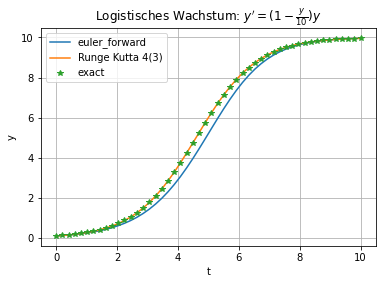

In [2]:
import numpy as np
import odesolver as ode
import matplotlib.pyplot as plt

lamb = 1.
K    = 10
y0 = np.array([0.1])    # Anfangswert
t0 = 0.                 # Anfangszeitpunkt
tf = 10.                # Endzeitpunkt
t_span = [t0, tf]       # Zeitintervall

# AWP
def flogistic(t, y):
    return lamb*(1. - y/K)*y
def y_log(t, t0, y0):
    return y0*np.exp(lamb*(t-t0))/((1. - y0/K) + y0*np.exp(lamb*(t-t0))/K)

# Test Euler
t_eval = np.linspace(t0,tf,50)
sol1 = ode.euler_forward(flogistic, t_span, y0, t_eval)
plt.plot(sol1.t, sol1.y[0,:], label='euler_forward')

# Test Runge Kuta
sol2 = ode.rungekutta_43(flogistic, t_span, y0)
plt.plot(sol2.t, sol2.y[0,:], label='Runge Kutta 4(3)')

# Exakte Lösung
fk_exakt = y_log(t_eval, t0, y0)
plt.plot(t_eval, fk_exakt, '*', label='exact')
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.title(r'Logistisches Wachstum: $y^\prime = (1 - \frac{y}{10})y$')

Text(0.5, 1.0, 'Fehler')

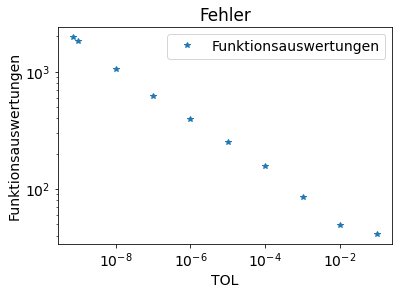

In [24]:
# Fehler-Analyse bei verschiedene Toleranz
import matplotlib.pyplot as plt
lamb = 1.
K    = 10
y0 = np.array([0.1])    # Anfangswert
t0 = 0.                 # Anfangszeitpunkt
tf = 10.                # Endzeitpunkt
t_span = [t0, tf]       # Zeitintervall
def f_logistic(t, y):
    return lamb*(1. - y/K)*y
def y_log(t, t0, y0):
    return y0*np.exp(lamb*(t-t0))/((1. - y0/K) + y0*np.exp(lamb*(t-t0))/K)

m = 10
TOLi = 1/10**(np.arange(m) + 1)         # Toleranz
Ei = np.zeros(len(TOLi))                # globale Fehler
eval_numbers_i = np.zeros(len(TOLi))    # Anzahl der Funktionsauswertungen


for k in range(len(TOLi)):
    solution = ode.rungekutta_43(f_logistic, t_span, y0, TOLi[k])
    yk_exakt = y_log(solution.t, t0, y0)           # Berechnung der Loesungswerte an den Gitterpunken
    yk       = solution.y
    Ei[k]    = np.linalg.norm( yk[0,:] - yk_exakt, np.inf)
    eval_numbers_i[k] = solution.eval_numbers

plt.plot(TOLi, eval_numbers_i, '*', label = r'Funktionsauswertungen')
plt.xlabel('TOL')
plt.ylabel('Funktionsauswertungen')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Fehler')

Die Anzahl der Funktionsauswertungen beim adaptiven Runge-Kutta-Verfahren erhöht sich bei kleinerer Toleranz. Es liegt daran, da sich die Schrittweite $h$ bei kleinerer Toleranz auch verkleinert.

###  Räuber-Beute-Modell

(Lotka-Volterra, $y_1$: Räuber, $y_2$: Beute, Konvention: alle Parameter $a,b,c,d \geq 0$)

\begin{equation}
\underbrace{y^\prime = \begin{pmatrix}y_1^\prime \\ y_2^\prime \end{pmatrix}
          = \begin{pmatrix} -a y_1 + b y_1 y_2 \\ c y_2 -  d y_1 y_2  \end{pmatrix}}_{\textrm{DGL}}, \qquad
          \underbrace{y(t_0) = y^0 = \begin{pmatrix} r^0\\ b^0 \end{pmatrix}}_{\textrm{Anfangswert}}
\end{equation}

mit $a=0.25$, $b=0.01$, $c=1$, $d=0.05$, $r^0=40$ und $b^0=20$

Text(0.5, 1.0, 'Raeuber-Beute-Modell')

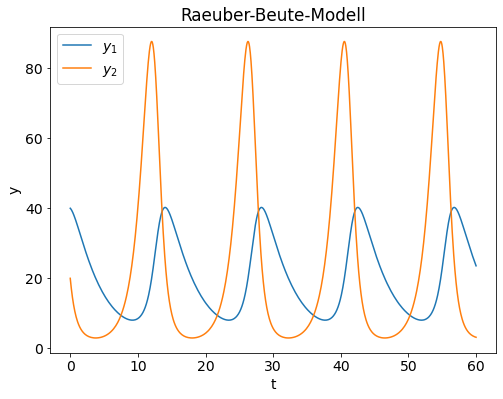

In [38]:
import matplotlib.pyplot as plt

y0 = [40, 20] # Anfangswert des Systems von DGLen, vektorwertig (oder "2 Anfangswerte")
t0 = 0.       # Anfangszeitpunkt
tf = 60.      # Endzeitpunkt
t_span = [t0, tf]       # Zeitintervall

#  Räuber-Beute-Modell
def lotka_volterra(t, y):
    return np.array( [-0.25*y[0] + 0.01*y[0]*y[1], y[1] - 0.05*y[0]*y[1]] )

# Test Runge Kuta
solution = ode.rungekutta_43(lotka_volterra, t_span, y0)
tk = solution.t
yk = solution.y
plt.figure(figsize=(8,6))
plt.plot(tk, yk[0,:], '-', label=r'$y_1$')
plt.plot(tk, yk[1,:], '-', label=r'$y_2$')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.title('Raeuber-Beute-Modell')

### Aufgabe 2:  Explosion

Die Lösung des folgenden AWPs geht in endlicher Zeit gegen $\infty$:

$$
y^\prime  = t y^2, \qquad y(0) = 1
$$

Exakte Lösung des AWPs lautet
$$
y = -\frac{2}{t^2-2}
$$

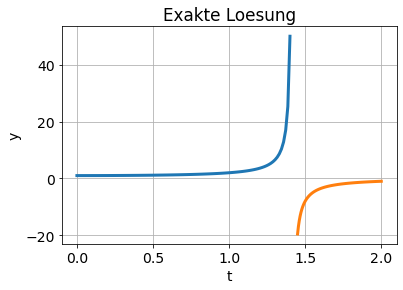

In [35]:
## Exakte Loesung
import matplotlib.pyplot as plt
def y_bsp1(t):
    '''Loesung y(t) mit Anfangswert y(t0) = y0'''
    return -2/(t**2-2)

t0       = 0
tf       = 2
N        = 100                        # Anzahl Zeitintervalle; Schrittweite h = (tf - t0)/N
# Zeitpunkte, an denen die Loesung ausgewertet/berechnet werden soll
tk1      = np.linspace(t0, 1.4, N+1)  # bis Wurzel 2
tk2      = np.linspace(1.45, tf, N+1) # ab Wurzel 2
yk_exakt1= y_bsp1(tk1)                # Berechnung der exakten Loesungswerte
yk_exakt2= y_bsp1(tk2)                # Berechnung der exakten Loesungswerte

## Grafische Darstellung
plt.rcParams.update({'font.size': 14})
plt.plot(tk1, yk_exakt1, '-', linewidth=3)
plt.plot(tk2, yk_exakt2, '-', linewidth=3)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Exakte Loesung')
plt.grid()


Die exakte Lösung hat um Punkt $x=\sqrt 2$ eine Asymtote
+ Bestimmen sie die exakte Lösung mit der Methode der Trennung der Variablen
+ Bestimmen sie jetzt mit eine Verfahren ohne Schrittweitensteuerung eine numerische Lösung auf dem Intervall $[0, 2]$. Was beobachten Sie?
+ Testen Sie jetzt das implementierte Verfahren mit adaptiver Schrittweite. *Findet* das Verfahren den Zeitpunkt $t_\infty$, an dem die Lösung $\infty$ wird? Es muss hier die Schrittweite gegen Null gehen.

Runge-Kutta wurde abgebrochen.
Abbruch bei t= 1.4142098869998554


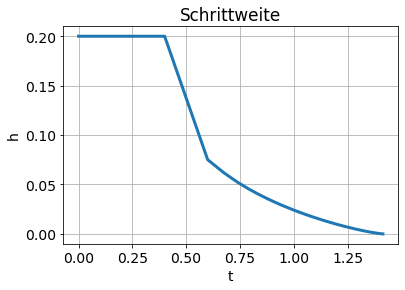

In [36]:
# AWP
def f(t,y):
    return t*y*y

t0       = 0
tf       = 2
y0 = np.array([1.])
t_span = [t0, tf]

#Loesung der Runge Kutta
sol = ode.rungekutta_43(f, t_span, y0)
tk = sol.t
hk = tk[1:] - tk[0:-1] # Schrittweite

# Lösung korrekt?
if sol.status == -1:
    print('Runge-Kutta wurde abgebrochen.')
    print('Abbruch bei t=', sol.t[-1])
    
# exakte lösung
tk = sol.t
yk_exakt = y_bsp1(tk)

## Grafische Darstellung
plt.rcParams.update({'font.size': 14})
plt.plot(tk[0:-1], hk, '-', linewidth=3)
plt.xlabel('t')
plt.ylabel('h')
plt.title('Schrittweite')
plt.grid()

Das adaptive Runge-Kutta-verfahren kann mit konstanter Schrittweite bis zum Punkt 0.4 unter gegebener Toleranz rechnen. Danach werden die Schrittweiten wegen dem starken Anstieg immer kleiner, bis schliesslich das Verfahren in der Nähe der Asymtoten abgebrochen wird.


### Singularität

Die rechte Seite des folgenden AWP hat an der Stelle $t= 0$ eine Singularität:

$$
y^\prime = -\frac{y}{t^2}, \qquad y(-1) = -1.
$$

Die exakte lösung lautet

$$
y = -exp(\frac{1}{t}+1)
$$


+ Bestimmen Sie die exakte Lösung $y(t)$ auf dem Intervall $t \in [-1, 0)$.
+ Testen Sie, ob das adaptive Verfahren die Singularität findet, also hier mit der Schrittweite gegen Null geht. (Ohne Abbruchbedingung würde das Verfahren also in eine Endlos-Schleife gehen.) Sie wählen dafür den Endzeitpunkt $t_f > 0 $. Wie verhält sich im Vergleich dazu ein Verfahren ohne Schrittweitensteuerung?


Runge-Kutta wurde abgebrochen.
Abbruch bei t= -5.991990098739144e-06


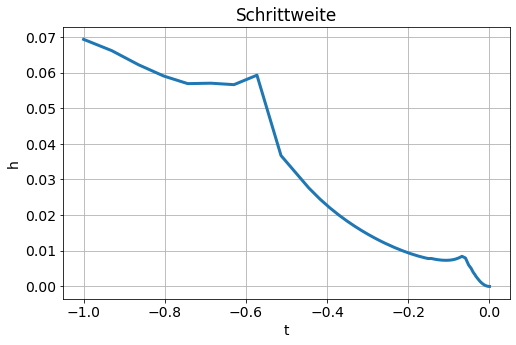

In [7]:
# AWP
def f(t,y):
    return -y/t**2

t0       = -1
tf       = -1e-10
y0 = np.array([1.])
t_span = [t0, tf]

#Loesung der Runge Kutta
sol = ode.rungekutta_43(f, t_span, y0)
tk = sol.t
hk = tk[1:] - tk[0:-1] # Schrittweite

# Lösung korrekt?
if sol.status == -1:
    print('Runge-Kutta wurde abgebrochen.')
    print('Abbruch bei t=', sol.t[-1])
    
# exakte lösung
tk = sol.t
yk_exakt = y_bsp1(tk)

## Grafische Darstellung
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(tk[0:-1], hk, '-', linewidth=3)
plt.xlabel('t')
plt.ylabel('h')
plt.title('Schrittweite')
plt.grid()

Das adaptive Runge-Kutta-Verfahren wurde in der Nähe von $t=0$ abgebrochen.

















































































































































### Restringiertes Dreikörperproblem

Betrachten Sie das folgende klassische *Test-Problem*: die Berechnung des Arenstorf-Orbits des *restringierten Dreikörperproblems*: 
	
Unter den vereinfachenden Annahmen, dass sich Erde, Mond und Satellit in einer Ebene bewegen, und dass sich Erde und Mond auf festen (bekannten) Kreisbahnen um ihren gemeinsamen Schwerpunkt bewegen, auf die der Satellit keinen Einfluß hat, ergeben sich aus dem Newtonschen Gravitationsgesetz die folgenden	
Differentialgleichungen der Bewegung eines Satelliten um das System Erde/Mond in den Koordinaten $y = (y_1,y_2)$ des mitrotierenden Schwerpunktsystems Erde-Mond
	\begin{align*}
			y_1^{\prime\prime} &= y_1 + 2y_2^\prime - \hat{\mu} \frac{y_1 + \mu}{N_1} - \mu\frac{y_1 - \hat{\mu}}{N_2} , \\
			y_2^{\prime\prime} &= y_2 - 2y_1^\prime - \hat{\mu} \frac{y_2}{N_1} - \mu\frac{y_2}{N_2} ,
	\end{align*}
	mit 
    
$$ 
     N_1 = \big( (y_1 + \mu)^2 + y_2^2 \big)^{3/2}, \quad  N_2 = \big( (y_1 - \hat{\mu})^2 + y_2^2 \big)^{3/2}
$$
 
  und den Parametern 
  
$$
    \mu = 0.012277471, \quad \hat{\mu} = 1 - \mu.
$$
  
  Dabei ist $\mu$ das Verhältnis von Mondmasse zur Masse des Gesamtsystems. Längeneinheit ist der euklidische Abstand Erde-Mond (ca. 
  384403 km), Zeiteinheit ein Monat. Mit den Anfangswerten 
  
$$
  	y_1(0) =  0.994, \quad y_1^\prime(0) = 0, \quad y_2(0) = 0, \quad y_2^\prime(0) = -2.001585106379082 , 
$$
  
  ergibt sich als Lösung der geschlossene kleeblattförmige *Arenstorf-Orbit* mit einer Periodendauer von (Genauigkeit $10^{-14}$)
  
  $$
  	T = 17.065216560157963.
 $$

---


In [4]:
# AWP des Arenstorf-Orbits des restringierten Dreikörperproblems
import matplotlib.pyplot as plt
def f_arenstorf(t,y):
    # DGl-System
    # y[0] = y1
    # y[1] = y2
    # y[2] = y1'
    # y[3] = y2'
    mu = 0.012277471
    mu_dach = 1 - mu
    N1 = ((y[0]+mu)**2 + y[1]**2)**1.5
    N2 = ((y[0]-mu_dach)**2 + y[1]**2)**1.5
    return np.array([y[2], y[3], y[0]+2*y[3]-mu_dach*(y[0]+mu)/N1-mu*(y[0]-mu_dach)/N2, y[1]-2*y[2]-mu_dach*y[1]/N1-mu*y[1]/N2])

y0 = np.array([0.994, 0., 0., -2.001585106379082])
t0 = 0.
tf = 17.065216560157963
t_span = [t0, tf]

Text(0.5, 1.0, 'Euler Verfahren h=0.01 fehler= 59.021409331739434')

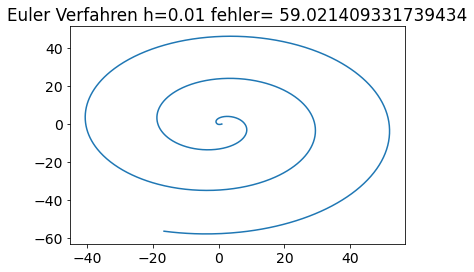

In [29]:
# Test Euler Verfahren
h = 1e-2
t_eval = np.arange(t0,tf+h,h)

#Loesung der Euler Verfahren
sol_euler = ode.euler_forward(f_arenstorf, t_span, y0, t_eval)
last_y_euler = [sol_euler.y[0,:][-1], sol_euler.y[1,:][-1]]
# geschaetzte Globale Fehler
err_global_euler = np.linalg.norm(y0[0:2] - last_y_euler)

## Grafische Darstellung
plt.plot(sol_euler.y[0,:], sol_euler.y[1,:])
plt.title('Euler Verfahren h=' + str(h)+' fehler= '+str(err_global_euler) )

Bei dem Euler-Verfahren mit Ordnung 1 muss man die Schrittweite h sehr klein wählen, um den Fehler verbessern zu können. Das Verfahren ist zu rechneintensiv, um genug kleinere Schrittweiten zu testen. 

Text(0.5, 1.0, 'Runge Kutta h=0.0001 fehler= 0.00016738409830175632')

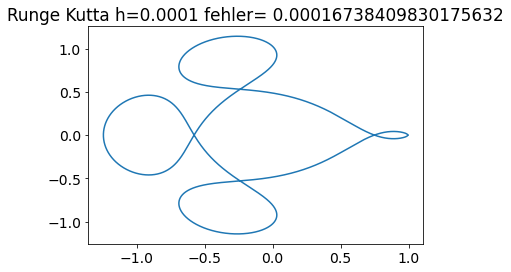

In [31]:
# Test Runge Kutta konstanter Schrittweite
h = 1e-4
t_eval = np.arange(t0,tf+h,h)

# Loesung der Runge Kutta konstanter Schrittweite
sol_rg = ode.rungekutta(f_arenstorf, t_span, y0, h)
last_y_rg = [sol_rg.y[0,:][-1], sol_rg.y[1,:][-1]]
# geschaetzte Globale Fehler
err_global_rg = np.linalg.norm(y0[0:2] - last_y_rg)

## Grafische Darstellung
plt.plot(sol_rg.y[0,:], sol_rg.y[1,:])
plt.title('Runge Kutta h=' + str(h) + ' fehler= ' + str(err_global_rg) )

Bei dem Runge-Kutta-Verfahren erhöht sich bei festen kleineren Schrittweiten die Anzahl der Funktionsauswertungen enorm. 

Text(0.5, 1.0, 'Runge Kutta (adaptive) tol=1e-14 fehler= 1.1262393640366015e-11')

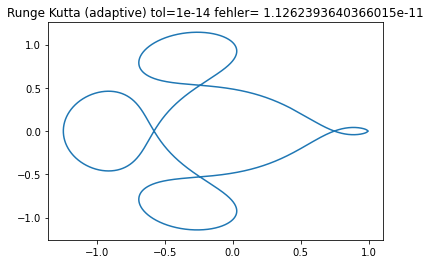

In [6]:
# Test Runge Kutta adaptive mit TOL = 10^-14
tol = 1e-14

#Loesung der Runge Kutta
sol = ode.rungekutta_43(f_arenstorf, t_span, y0, tol)
tk = sol.t
last_y = [sol.y[0,:][-1], sol.y[1,:][-1]]
# geschaetzte Globale Fehler
err_global = np.linalg.norm(y0[0:2] - last_y)

# Lösung korrekt?
if sol.status == -1:
    print('Runge-Kutta wurde abgebrochen.')
    print('Abbruch bei t=', sol.t[-1])

## Grafische Darstellung
plt.plot(sol.y[0,:], sol.y[1,:])
plt.title('Runge Kutta (adaptive) tol=' + str(tol) + ' fehler= ' + str(err_global) )

Bei dem adaptiven Runge Kutta Verfahren haben wir den Toleranz $TOL=1e-14$ gewählt. Der globale Fehler betrug $1e-11$.